In [1]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
! pip install spectral

URL transformed to HTTPS due to an HSTS policy
--2024-09-20 16:37:25--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.3’

Indian_pines_correc 100%[===================>]   5.68M  1.21MB/s    in 4.7s    

2024-09-20 16:37:31 (1.21 MB/s) - ‘Indian_pines_corrected.mat.3’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2024-09-20 16:37:31--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat.3’

Indian_pines_gt.mat 100%[===================>]   1.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
class_nums = 16
inchannels = 30
patch_size = 25

class HybridSN(nn.Module):
  def __init__(self):
    super(HybridSN, self).__init__()
    self.inchannel = inchannels
    self.patch_size = patch_size
    self.class_nums = class_nums
    self.conv1 = nn.Sequential(
        nn.Conv3d(in_channels = 1,out_channels = 8, kernel_size=(7,3,3)),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.Conv3d(in_channels = 8,out_channels = 16, kernel_size=(5,3,3)),
        nn.ReLU(),
    )
    self.conv3 = nn.Sequential(
        nn.Conv3d(in_channels = 16,out_channels = 32, kernel_size=(3,3,3)),
        nn.ReLU(),
    )
    self.x1_shape = self.get_shape1()

    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = self.x1_shape[1]*self.x1_shape[2],out_channels = 64, kernel_size=(3,3)),
        nn.ReLU(),
    )
    self.x2_shape = self.get_shape2()
    self.fc1 = nn.Sequential(
        nn.Linear(self.x2_shape[1]*self.x2_shape[2]*self.x2_shape[3],256),
        nn.ReLU(),
        nn.Dropout(0.4),
    )
    self.fc2 = nn.Sequential(
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Dropout(0.4),
    )
    self.fc3 = nn.Linear(128,self.class_nums)

  def get_shape1(self):
    x = torch.zeros(1,1,self.inchannel,self.patch_size,self.patch_size)
    with torch.no_grad():
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
    return x.shape

  def get_shape2(self):
    x = torch.zeros(1,self.x1_shape[1]*self.x1_shape[2],self.x1_shape[3],self.x1_shape[4])
    with torch.no_grad():
      x = self.conv4(x)
    return x.shape

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), x.size(1)*x.size(2), x.size(3),x.size(4))
    # print(x.shape)
    x = self.conv4(x)
    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))
    # print(x.shape)
    x = self.fc1(x)
    x = self.fc2(x)
    out = self.fc3(x)
    return out


In [4]:
x = torch.randn(1, 1, 30, 25, 25)
net = HybridSN()

In [5]:
y = net(x)
print(y.shape)

torch.Size([1, 16])


In [6]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape)
print('before transpose: Xtest  shape: ', Xtest.shape)

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape)
print('after transpose: Xtest  shape: ', Xtest.shape)


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


In [8]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
total_loss = 0
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

print('Finished Training')

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[Epoch: 1]   [loss avg: 23.6732]   [current loss: 2.7615]
[Epoch: 2]   [loss avg: 22.4398]   [current loss: 2.5170]
[Epoch: 3]   [loss avg: 21.5919]   [current loss: 2.4541]
[Epoch: 4]   [loss avg: 21.0778]   [current loss: 2.4197]
[Epoch: 5]   [loss avg: 20.6953]   [current loss: 2.4848]
[Epoch: 6]   [loss avg: 20.3585]   [current loss: 2.2622]
[Epoch: 7]   [loss avg: 20.0609]   [current loss: 2.0977]
[Epoch: 8]   [loss avg: 19.7982]   [current loss: 2.2652]
[Epoch: 9]   [loss avg: 19.5257]   [current loss: 2.0617]
[Epoch: 10]   [loss avg: 19.1718]   [current loss: 1.9888]
[Epoch: 11]   [loss avg: 18.7827]   [current loss: 1.7743]
[Epoch: 12]   [loss avg: 18.3622]   [current loss: 1.6333]
[Epoch: 13]   [loss avg: 17.8912]   [current loss: 1.4902]
[Epoch: 14]   [loss avg: 17.4037]   [current loss: 1.4009]
[Epoch: 15]   [loss avg: 16.9022]   [current loss: 1.4341]
[Epoch: 16]   [loss avg: 16.4018]   [current loss: 1.0113]
[Epoch: 17]   [loss avg: 15.8930]   [current loss: 0.8154]
[Epoch

In [9]:
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     0.9750    0.9512    0.9630        41
         1.0     0.9774    0.9097    0.9424      1285
         2.0     0.9362    0.8835    0.9091       747
         3.0     0.8986    0.9155    0.9070       213
         4.0     0.9254    0.9701    0.9473       435
         5.0     0.9833    0.9848    0.9840       657
         6.0     0.7667    0.9200    0.8364        25
         7.0     0.9705    0.9953    0.9828       430
         8.0     0.4667    0.3889    0.4242        18
         9.0     0.9159    0.9703    0.9423       875
        10.0     0.9719    0.9706    0.9712      2210
        11.0     0.8816    0.9345    0.9073       534
        12.0     0.9881    0.8973    0.9405       185
        13.0     0.9921    0.9965    0.9943      1139
        14.0     0.9185    0.9741    0.9455       347
        15.0     0.7586    0.7857    0.7719        84

    accuracy                         0.9526      9225
   macro avg     0.8954   

In [10]:
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (test_loader, y_test, name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred =  outputs
            count = 1
        else:
            y_pred = np.concatenate( (y_pred, outputs) )

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

In [11]:
classification, confusion, oa, each_acc, aa, kappa = reports(test_loader, ytest, 'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [12]:
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

/tmp/ipykernel_11551/1433302639.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction+1


... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


/root/miniconda3/lib/python3.12/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


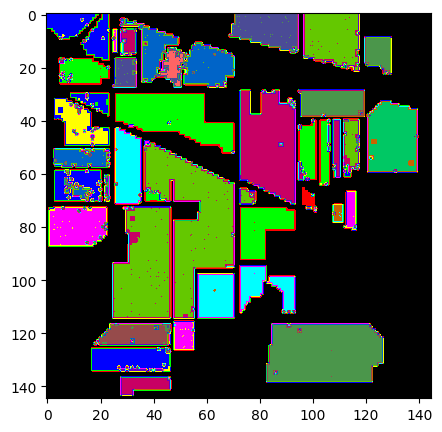

In [13]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))